In [7]:
import pickle as pkl
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
from voltron.data import make_ticker_list, GetStockHistory

sns.set_style('white')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

In [8]:
matern_df = pd.read_pickle("./matern_calib.pkl")
volt_df = pd.read_pickle("./volt_calib.pkl")
matern_df.columns = volt_df.columns

In [9]:
matern_df.Mean.unique()

array(['tewma', 'linear', 'constant', 'ewma'], dtype=object)

In [10]:
def ECDF(sample_pxs, true_px):    
    return (torch.sum(sample_pxs < true_px, 0)/sample_pxs.shape[0])
 
def Calibration(pcts, percentile=0.95):
    in_band = np.where((pcts < percentile))[0].shape[0]
    return in_band/pcts.shape[0]

def GetCalibration(model, horizon=np.arange(75,100), 
                   logger=[], exp=True):
    

    ntrain = 400
    n_test_times = 20
    ntest = 100
    pcts = torch.tensor([])
    for tckr in ticker_list:
        data = GetStockHistory(tckr, history=1000, end_date=end_date)
        for idx, date in enumerate(data.index):

            fpath = "./saved-outputs/"+ tckr + "/"
            fname = model + "_"
            if model == 'volt':
                fname +=  "constant"

            fname += str(date.date()) + ".pt"


            if os.path.exists(fpath + fname): 
                preds = torch.load(fpath + fname)
                if isinstance(preds, tuple):
                    preds = preds[0]
                
                if preds.shape[-1] == 100:
                    preds = preds[:, horizon]

                    test_y = torch.tensor(data.iloc[idx:idx+100].Close.to_numpy())
                    if test_y.shape[0] == 100:
                        if exp:
                            preds = preds.exp()
                        pcts = torch.cat((pcts, ECDF(preds, test_y[horizon])))
            
    if pcts.numel() == 0:
        return logger
    
    pcts = pcts.flatten().numpy()
    percentiles = np.linspace(0.05, 0.95, 19)
    for pct in percentiles:
        clb = Calibration(pcts, pct)
        logger.append([clb, np.round(pct, 2), model, "Constant", 100])
        
    return logger

In [11]:
data_path = "../../voltron/data/"
ticker_list = make_ticker_list(data_path + "test_tickers.txt")

In [12]:
end_date = "2022-01-13"

In [13]:
log = []
for model in ['volt', 'lstm']:
    log = GetCalibration(model, horizon=np.arange(75,100), 
                   logger=log, exp=True)

In [14]:
df = pd.DataFrame(log)
df.columns = ['Calibration', 'Percentile', "Model", "Mean", "k"]

In [26]:
df

,Calibration,Percentile,Model,Mean,k
0,0.024371,0.05,volt,Constant,100
1,0.031473,0.10,volt,Constant,100
2,0.042644,0.15,volt,Constant,100
3,0.058020,0.20,volt,Constant,100
4,0.073815,0.25,volt,Constant,100
...,...,...,...,...,...
337,0.793388,0.75,volt,tewma,400
338,0.812314,0.80,volt,tewma,400
339,0.840826,0.85,volt,tewma,400
340,0.879091,0.90,volt,tewma,400


In [15]:
df = pd.concat([df, matern_df, volt_df])

In [16]:
mat_df = df[(df['Model'] == 'matern') & (df['Mean'] == 'tewma') & (df['k'] == 400)]
lstm_df = df[df['Model']=='lstm']
volt_df = df[(df['Model'] == 'volt') & (df['Mean'] == 'ewma') & (df['k']==100)]
plt_df = pd.concat([lstm_df, mat_df, volt_df])

In [27]:
mat_df = df[(df['Model'] == 'matern') & (df['Mean'] == 'constant')]
volt_df = df[(df['Model'] == 'volt') & (df['Mean'] == 'Constant')]
const_df = pd.concat([mat_df, volt_df])

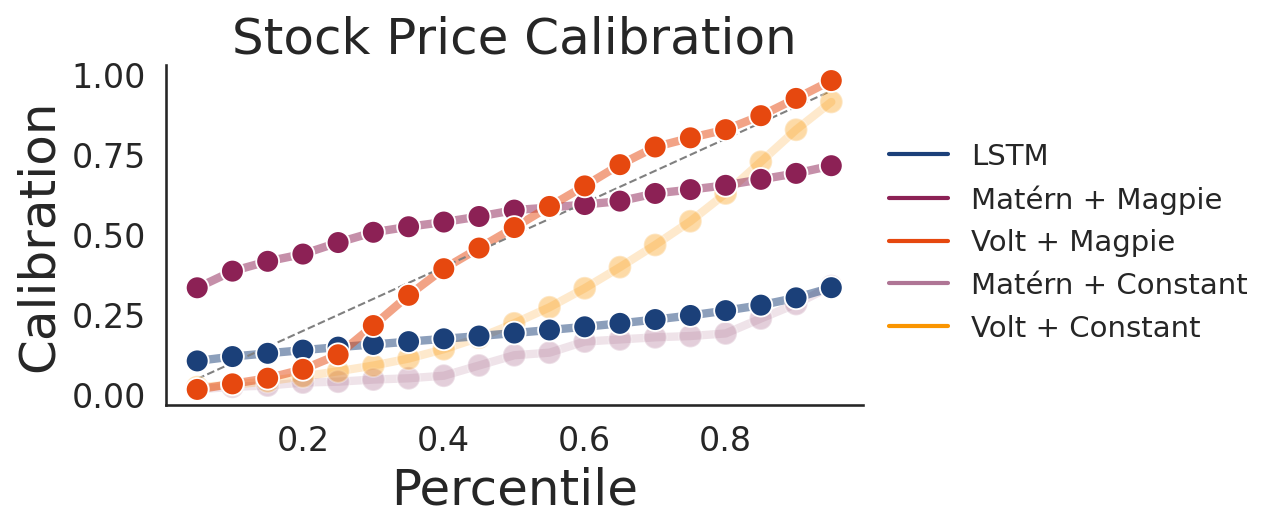

In [41]:



from matplotlib.lines import Line2D
fig, ax = plt.subplots(1,1,dpi=150, figsize=(6, 3))

percentiles = np.linspace(0.05, 0.95, 19)


pal = [palette[5], palette[7]]
# pal = [palette[5]]
sns.lineplot(x='Percentile', y="Calibration", hue='Model', data=const_df, ax=ax, alpha=0.2,
            palette=pal, legend=True)
sns.scatterplot(x='Percentile', y="Calibration", hue='Model', data=const_df, ax=ax, s=120, legend=False, zorder=4,
               palette=pal, alpha=0.35)

pal = [ palette[0], palette[4], palette[6]]
sns.lineplot(x='Percentile', y="Calibration", hue='Model', data=plt_df, ax=ax, alpha=0.5,
            palette=pal, legend=True)
sns.scatterplot(x='Percentile', y="Calibration", hue='Model', data=plt_df, ax=ax, s=120, legend=False, zorder=4,
               palette=pal)
x = np.linspace(0.05,0.95)
y = np.linspace(0, len(percentiles))
ax.plot(x, x, color="gray", lw=1., ls="--")
ax.set_title("Stock Price Calibration")



plt.tick_params(labelsize=16)
sns.despine()

custom_lines = [Line2D([0], [0], color=palette[0], lw=2),
               Line2D([0], [0], color=palette[4], lw=2),
               Line2D([0], [0], color=palette[6], lw=2),
               Line2D([0], [0], color=palette[5], lw=2),
               Line2D([0], [0], color=palette[7], lw=2)]


plt.legend(custom_lines, ['LSTM', r"Matérn + Magpie", "Volt + Magpie", "Matérn + Constant",
                         "Volt + Constant"],
           fontsize=14, frameon=False, bbox_to_anchor=(1., 0.85))
# ax.legend(fontsize=14, bbox_to_anchor=(1., 0.75))
# plt.label("Percentile")
plt.savefig("./stock_calibration.pdf", bbox_inches="tight")
plt.show()